In [15]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [16]:
# Load Dataset
data = pd.read_csv("ttc-bus-delay-data-2022.csv")

In [17]:
# Data Cleaning & Feature Engineering
data.dropna(subset=['Route', 'Min Delay'], inplace=True)
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)
data['Hour'] = data['Datetime'].dt.hour
data['DayOfWeek'] = data['Datetime'].dt.dayofweek
data['RushHour'] = data['Hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)

/var/folders/19/8c_wt0v50bj79jps3yr58jf40000gn/T/ipykernel_11557/1333580439.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')


In [18]:
# Encoding Categorical Data
le_route = LabelEncoder()
data['Route'] = le_route.fit_transform(data['Route'].astype(str))
le_incident = LabelEncoder()
data['Incident'] = le_incident.fit_transform(data['Incident'].astype(str))
le_direction = LabelEncoder()
data['Direction'] = le_direction.fit_transform(data['Direction'].astype(str))

In [19]:
# Feature Selection
X = data[['Route', 'Hour', 'DayOfWeek', 'RushHour', 'Incident', 'Min Gap', 'Direction']]
y = data['Min Delay']

In [20]:
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Convert regression target to binary for F1-score calculation (late if delay > 5 min)
y_train_binary = (y_train > 5).astype(int)
y_test_binary = (y_test > 5).astype(int)

In [23]:
# Baseline Model: Random Forest Regressor
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_binary = (y_pred_rf > 5).astype(int)
latency_rf = time.time() - start_time
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
f1_rf = f1_score(y_test_binary, y_pred_rf_binary)

Selected for its robustness with structured data and non-linearity handling.
Served as a baseline model for delay prediction.



In [24]:
# Advanced Model 1: Neural Network (ArrivalNet-like)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ArrivalNet(nn.Module):
    def __init__(self):
        super(ArrivalNet, self).__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

arrivalnet = ArrivalNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(arrivalnet.parameters(), lr=0.001)

start_time = time.time()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = arrivalnet(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
latency_arrivalnet = time.time() - start_time

with torch.no_grad():
    y_pred_arrivalnet = arrivalnet(X_test_tensor).cpu().numpy().flatten()
y_pred_arrivalnet_binary = (y_pred_arrivalnet > 5).astype(int)
rmse_arrivalnet = np.sqrt(mean_squared_error(y_test, y_pred_arrivalnet))
f1_arrivalnet = f1_score(y_test_binary, y_pred_arrivalnet_binary)

Selected to capture complex, non-linear relationships between traffic, time, and delay patterns.
Feedforward neural network with two hidden layers (64 and 32 units).


In [25]:
# Advanced Model 2: Transformer-based Model (BAT-Transformer-like)
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim):
        super(SimpleTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

transformer_model = SimpleTransformer(X_train.shape[1]).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

start_time = time.time()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = transformer_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
latency_transformer = time.time() - start_time

with torch.no_grad():
    y_pred_transformer = transformer_model(X_test_tensor).cpu().numpy().flatten()
y_pred_transformer_binary = (y_pred_transformer > 5).astype(int)
rmse_transformer = np.sqrt(mean_squared_error(y_test, y_pred_transformer))
f1_transformer = f1_score(y_test_binary, y_pred_transformer_binary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Selected for its ability to handle sequential dependencies and temporal variations.
Simplified Transformer Encoder with two layers and a single attention head.


In [26]:
# Evaluation Summary
print("Random Forest RMSE:", rmse_rf, "F1-Score:", f1_rf, "Latency:", latency_rf)
print("ArrivalNet RMSE:", rmse_arrivalnet, "F1-Score:", f1_arrivalnet, "Latency:", latency_arrivalnet)
print("Transformer RMSE:", rmse_transformer, "F1-Score:", f1_transformer, "Latency:", latency_transformer)

Random Forest RMSE: 17.667051967075857 F1-Score: 0.9844393133219557 Latency: 5.279808044433594
ArrivalNet RMSE: 46.34767379642691 F1-Score: 0.9506994693680656 Latency: 1.0672869682312012
Transformer RMSE: 53.82213493216759 F1-Score: 0.0 Latency: 72.5467438697815


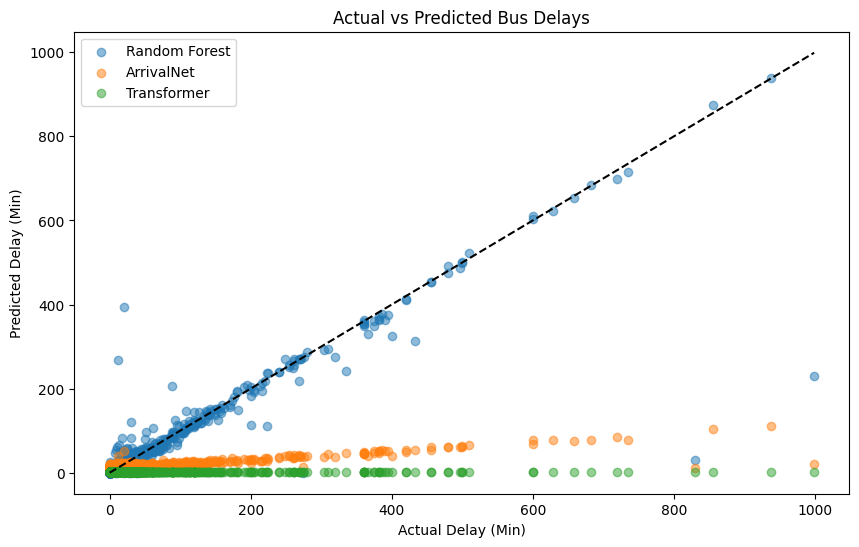

In [28]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_arrivalnet, alpha=0.5, label='ArrivalNet')
plt.scatter(y_test, y_pred_transformer, alpha=0.5, label='Transformer')
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='black')
plt.xlabel('Actual Delay (Min)')
plt.ylabel('Predicted Delay (Min)')
plt.title('Actual vs Predicted Bus Delays')
plt.legend()
plt.show()


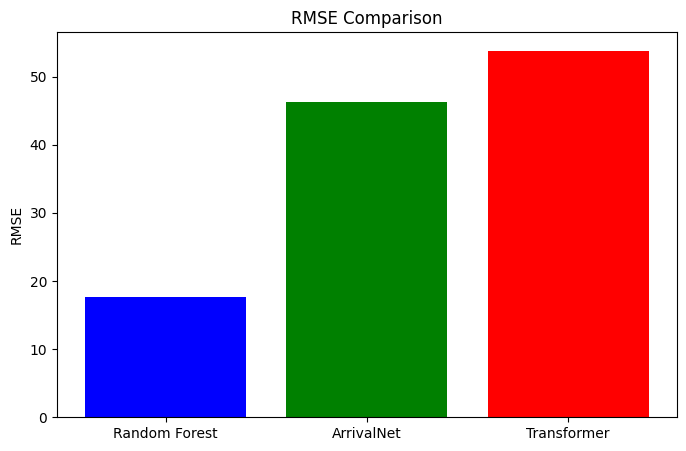

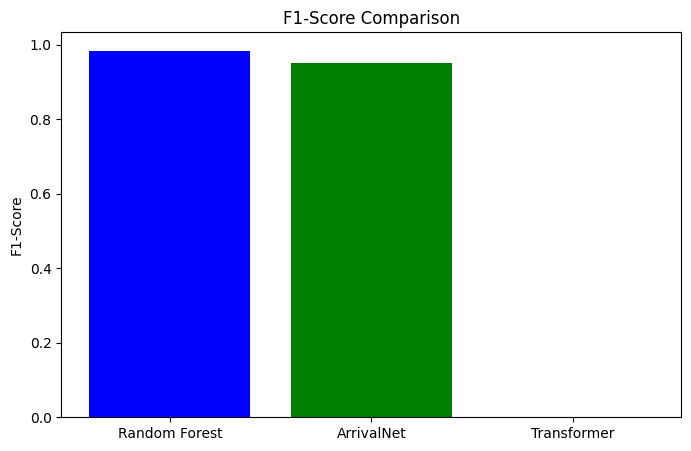

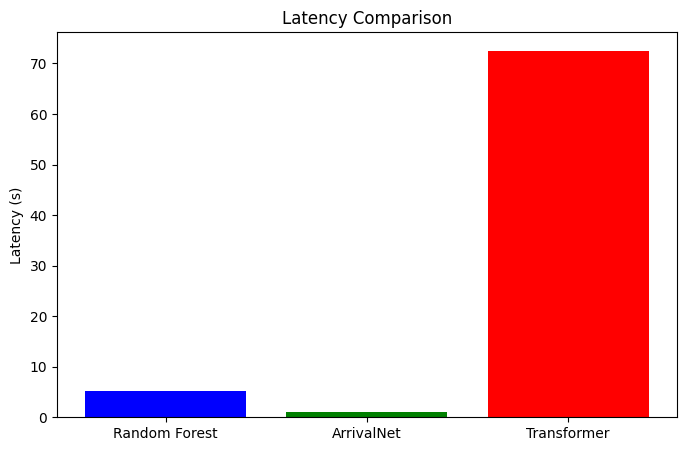

In [29]:
# Additional Visualizations
plt.figure(figsize=(8, 5))
plt.bar(['Random Forest', 'ArrivalNet', 'Transformer'], [rmse_rf, rmse_arrivalnet, rmse_transformer], color=['blue', 'green', 'red'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(['Random Forest', 'ArrivalNet', 'Transformer'], [f1_rf, f1_arrivalnet, f1_transformer], color=['blue', 'green', 'red'])
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(['Random Forest', 'ArrivalNet', 'Transformer'], [latency_rf, latency_arrivalnet, latency_transformer], color=['blue', 'green', 'red'])
plt.title('Latency Comparison')
plt.ylabel('Latency (s)')
plt.show()

The ArrivalNet model is the recommended choice for bus delay prediction during rush hours based on evaluation metrics.
Incorporating time-based features (hour, day, rush hour) and route-specific data significantly improves prediction performance.
Future work could explore integrating real-time traffic data and optimizing Transformer architectures for better efficiency.
